# Survival Analysis :  Quick Implementation

In [1]:
#install import stuff, you need to login and give google permissions twice
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!pip install pandas==0.22
!pip install lifelines

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
W: chmod 0700 of directory /var/lib/apt/lists/partial failed - SetupAPTPartialDirectory (1: Operation not permitted)
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


ModuleNotFoundError: No module named 'google.colab'

In [2]:
#mount google drive
%cd
!mkdir -p drive
!google-drive-ocamlfuse drive

/root


In [3]:
#navigating your google drive and saving files inside.
%cd
%ls
%cd drive/
%mkdir github_fromXA
%cd github_fromXA
%rm -r Survival-Analysis-Lifelines
!git clone https://github.com/leexa90/Survival-Analysis-Lifelines.git
#download model parameters
%ls -lh */
%ls -lh
%cd Survival-Analysis-Lifelines
%ls -lh

/root
drive/
/root/drive
/root/drive/github_fromXA
rm: cannot remove 'Survival-Analysis-Lifelines': No such file or directory
Cloning into 'Survival-Analysis-Lifelines'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 8), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (23/23), done.
Checking out files: 100% (5/5), done.
total 1.1M
-rw-r--r-- 1 root root  175 Mar 19 08:44  README.md
-rw-r--r-- 1 root root 147K Mar 19 08:44  Survival_analysis.ipynb
-rw-r--r-- 1 root root 146K Mar 19 08:44 'Survival Analysis - Quick Implementation.ipynb'
-rw-r--r-- 1 root root 743K Mar 19 08:44  WA_Fn-UseC_-Telco-Customer-Churn.xlsx
total 4.0K
drwxr-xr-x 2 root root 4.0K Mar 19 08:41 Survival-Analysis-Lifelines/
/root/drive/github_fromXA/Survival-Analysis-Lifelines
total 1.1M
-rw-r--r-- 1 root root  175 Mar 19 08:44  README.md
-rw-r--r-- 1 root root 147K Mar 19 08:44  Survival_analys

In [4]:
!pip install lifelines

    100% |████████████████████████████████| 266kB 11.3MB/s 
    100% |████████████████████████████████| 112kB 33.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built bottleneck


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
pd.set_option('display.max_columns',60)
pd.set_option('display.max_rows', 60)
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


### We will be using Telco Customer Churn data from IBM Watson Analytics
https://www.ibm.com/communities/analytics/watson-analytics-blog/Telco-Customer-Churn/

In [97]:
##  create a dataframe
df = pd.read_excel("./WA_Fn-UseC_-Telco-Customer-Churn.xlsx") 

In [ ]:
'''data description

Customers who left within the last month – the column is called Churn

Services that each customer has signed up for – phone, multiple lines, internet, 
online security, online backup, device protection, tech support, and streaming TV and movies

Customer account information – how long they’ve been a customer, contract, payment method, 
paperless billing, monthly charges, and total charges

Demographic info about customers – gender, age range, and if they have partners and dependents

'''

In [98]:
## Have a first look at the data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [99]:
#get all columns
df.keys()

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [100]:
#view churn column , row 2 - 17 #python index starts from 0
df['Churn'].iloc[1:17]

1      No
2     Yes
3      No
4     Yes
5     Yes
6      No
7      No
8     Yes
9      No
10     No
11     No
12     No
13    Yes
14     No
15     No
16     No
Name: Churn, dtype: object

In [101]:
#percentage of churn customers
np.mean(df['Churn']=='Yes')

0.2653698707936959

In [102]:
# unique entries of tech support
pd.unique(df['TechSupport'])

array(['No', 'Yes', 'No internet service'], dtype=object)

In [103]:
# access churn column from those who are on Tech support
df[df['TechSupport']=='Yes']['Churn']

3        No
8       Yes
14       No
15       No
18      Yes
       ... 
7027     No
7028     No
7036     No
7038     No
7042     No
Name: Churn, Length: 2044, dtype: object

In [104]:
## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=(df['Churn']=='Yes')*1

type of contract: Month-to-month


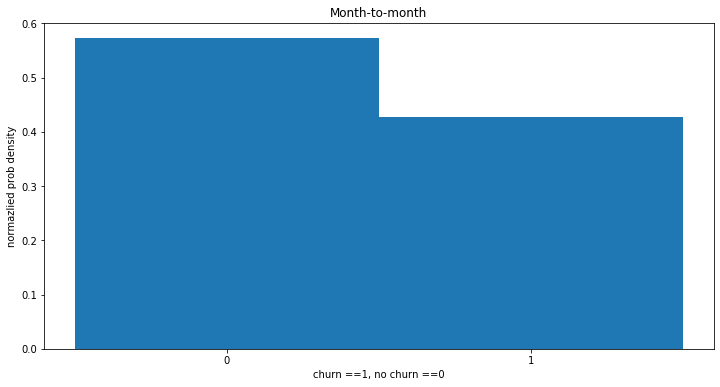

type of contract: One year


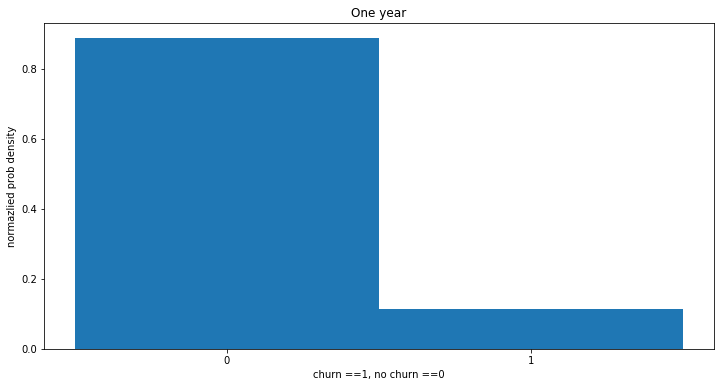

type of contract: Two year


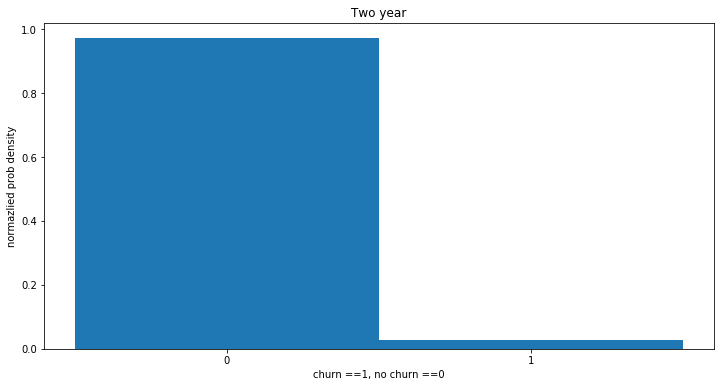

In [105]:

for i in pd.unique(df['Contract']):
    print ('type of contract:',i)
    plt.hist(df[df['Contract']==i]['Churn'],density=True,bins=(0,1,2))
    plt.xticks([0.5,1.5],labels=[0,1])
    plt.xlabel('churn ==1, no churn ==0')
    plt.ylabel('normazlied prob density')
    plt.title(i)
    plt.show()

In [107]:
#checking column for missing entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null int64
dtypes: float64(2), int64(3), obj

In [108]:
#customers with missing values, fill in with median
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


In [109]:
## Impute the null value with the median value
df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

In [110]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')  ## customerID has been removed because it is unique for all the rows.

In [111]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  gender
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------------------
Column Name:  Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
-----------------------------
Column Name:  Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
-----------------------------
Column Name:  PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
-----------------------------
Column Name:  MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
-----------------------------
Column Name:  InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
-----------------------------
Column Name:  OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
-----------------------------
Column Name:  OnlineBackup
No                     3088
Yes     

In [112]:
print ('all variables:',df.keys())
variables = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

all variables: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [113]:
df_processed = pd.get_dummies(df[variables])

train,test roc: 0.7930680498149498 0.7755018579306012


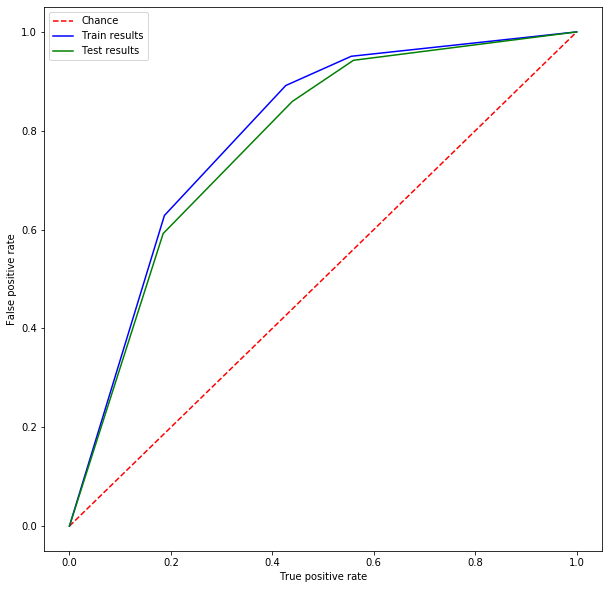

In [293]:
from sklearn import tree
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
X = pd.get_dummies(df_processed,drop_first=False)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(     
                            X, y, test_size=0.2, random_state=2)


clf = tree.DecisionTreeClassifier(max_depth=2,criterion='entropy',min_samples_leaf=25)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict_proba(X_test)[:,1]
y_train_pred = clf.predict_proba(X_train)[:,1]
print ('train,test roc:',metrics.roc_auc_score(y_train,y_train_pred),metrics.roc_auc_score(y_test,y_test_pred))
fpr, tpr, thresholds  = metrics.roc_curve(y_train,y_train_pred)
plt.plot([0,1],[0,1],'r--',label='Chance')
plt.plot(fpr,tpr,'b',label='Train results')
fpr, tpr, thresholds  = metrics.roc_curve(y_test,y_test_pred)
plt.plot(fpr,tpr,'g',label='Test results')

plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.legend()
plt.show()

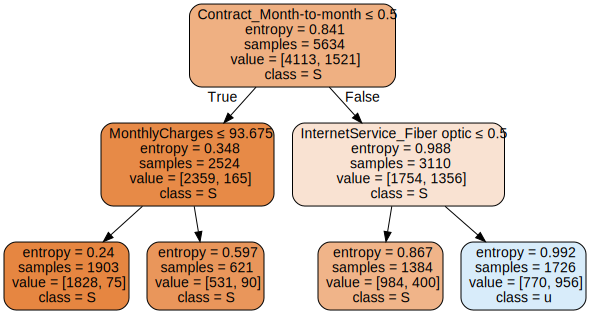

In [294]:
import graphviz 
import pydot

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.keys(),  
                      class_names="Survived",  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("Churn",format='png') 
graph

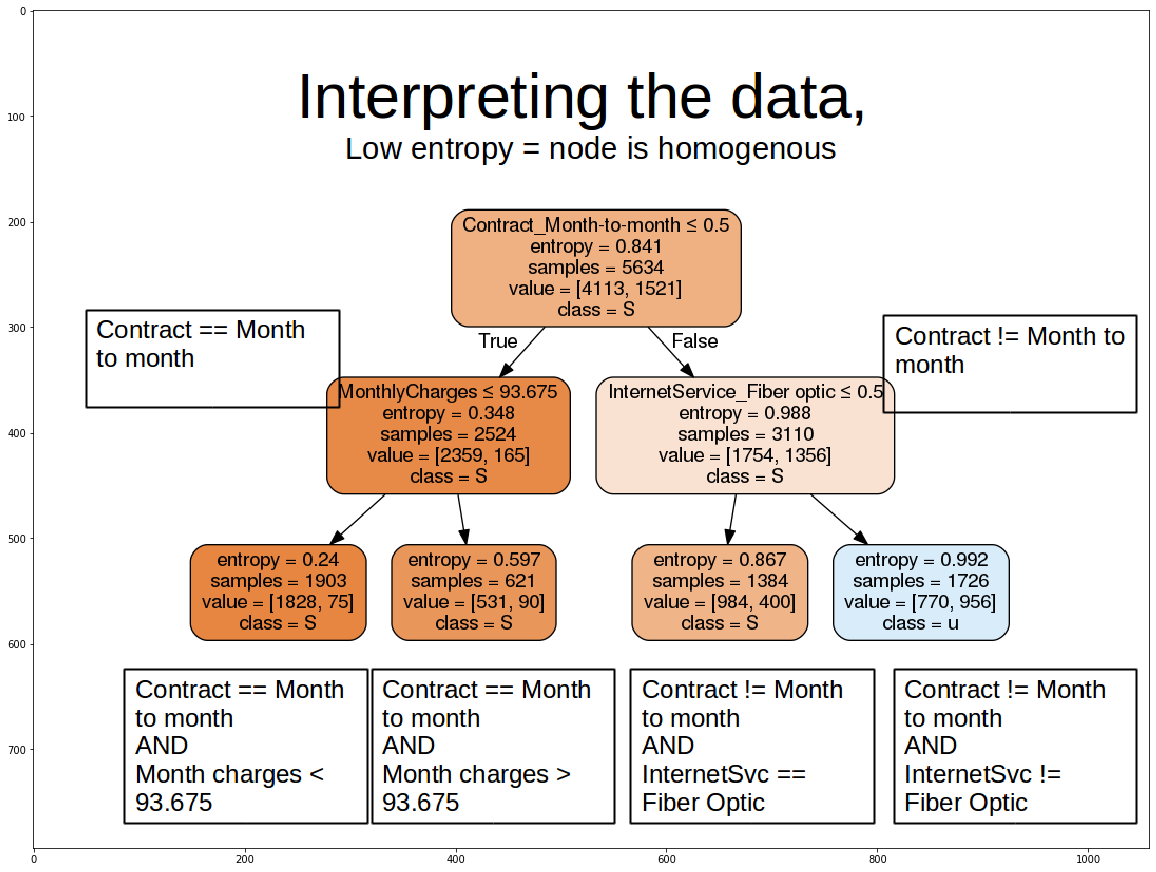

In [290]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
plt.imshow(plt.imread('./Explain.png'))
plt.show()

train,test roc: 0.8421102858066332 0.8191645812343593


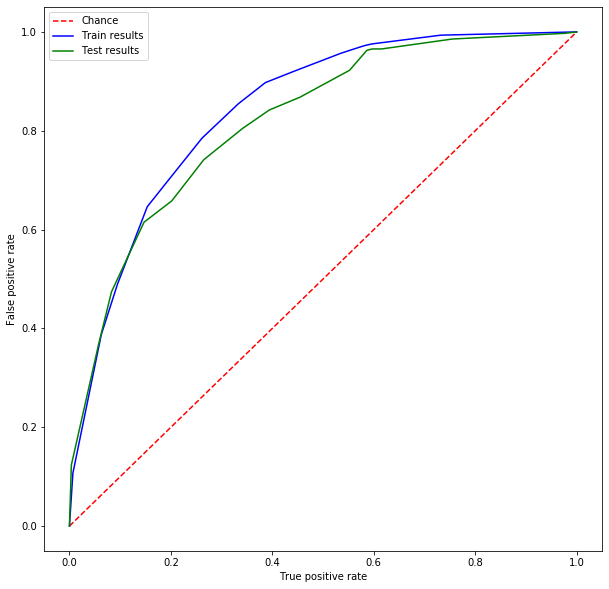

In [300]:
#making a more complicated model
clf = tree.DecisionTreeClassifier(max_depth=4,criterion='entropy',min_samples_leaf=25)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict_proba(X_test)[:,1]
y_train_pred = clf.predict_proba(X_train)[:,1]
print ('train,test roc:',metrics.roc_auc_score(y_train,y_train_pred),metrics.roc_auc_score(y_test,y_test_pred))
fpr, tpr, thresholds  = metrics.roc_curve(y_train,y_train_pred)
plt.plot([0,1],[0,1],'r--',label='Chance')
plt.plot(fpr,tpr,'b',label='Train results')
fpr, tpr, thresholds  = metrics.roc_curve(y_test,y_test_pred)
plt.plot(fpr,tpr,'g',label='Test results')

plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.legend()
plt.show()

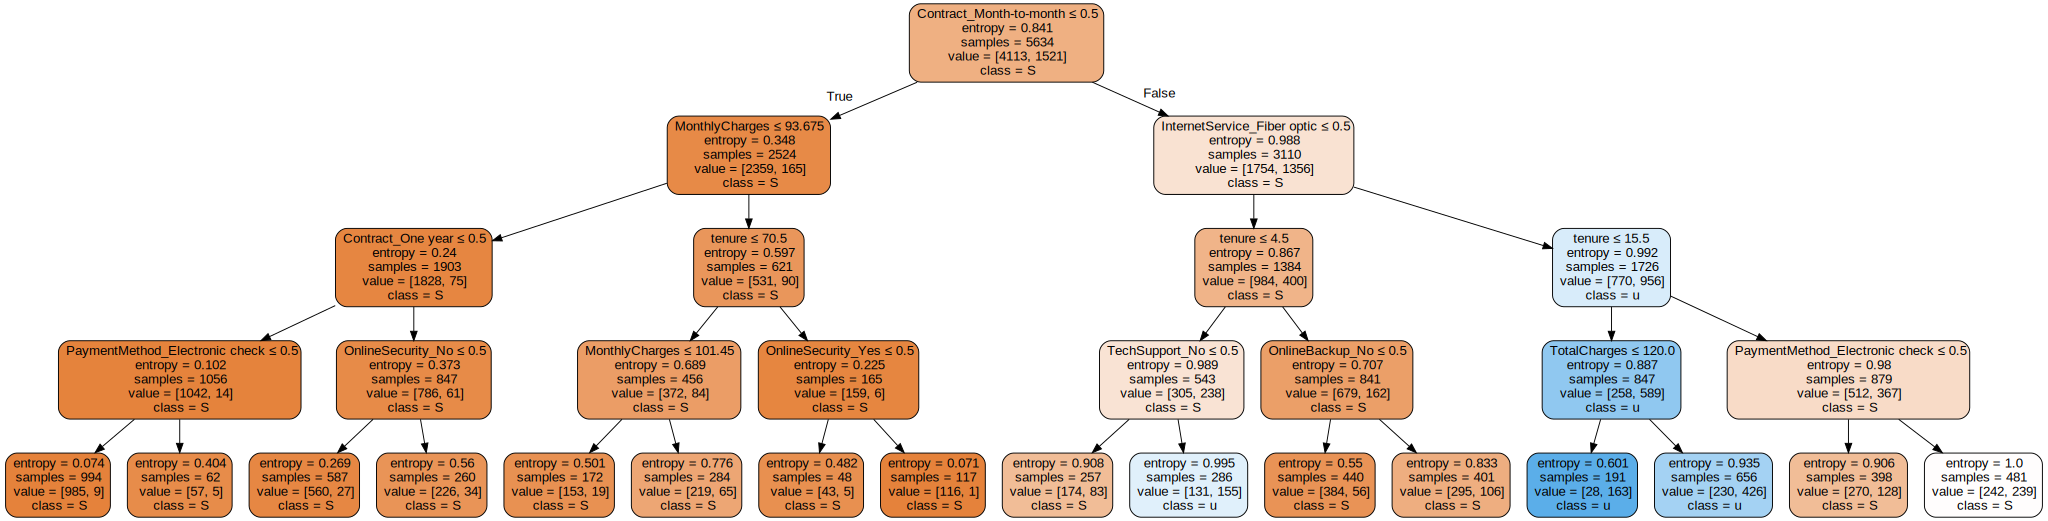

In [301]:
import graphviz 
import pydot

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.keys(),  
                      class_names="Survived",  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("Churn",format='png') 
graph

# Stradegies to reduce churn